## Cell 1: Environment Setup & Library Imports
This initial cell sets up our working environment. We import `pandas` and `numpy` for data manipulation, and `matplotlib` and seaborn for Exploratory Data Analysis (EDA). For our machine learning objectives, we import `scikit-learn` (for preprocessing, regression, and evaluation metrics) , `lightgbm` for efficient classification , and the `surprise` library to build our collaborative filtering recommendation system.
We need to import `LinearRegression` and `LogisticRegression` from `scikit-learn` to act as our baseline models.

In [16]:
# Cell 1: Imports and Setup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing & Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, LogisticRegression # <-- NEW IMPORT
import lightgbm as lgb

# Evaluation Metrics
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

# Recommendation System
from surprise import Dataset, Reader, SVD
from surprise.model_selection import train_test_split as surprise_train_test_split
from surprise import accuracy

# Set visualization style
sns.set_theme(style="whitegrid")
import warnings
warnings.filterwarnings('ignore')

## Cell 2: Data Loading & Relational Consolidation
he tourism dataset is highly relational, spread across multiple tables . Here, we load all relevant data files, including the `Updated_Item.xlsx` which contains the most accurate attraction details. We then perform sequential merges to build a consolidated master dataset. We ensure proper handling of overlapping IDs, such as differentiating between a User's City and an Attraction's City .

In [17]:
# Cell 2: Data Loading and Consolidation

# Define the base directory path
base_path = r"D:\GITHUB projects\Tourism\Tourism Dataset"

# 1. Load Data
transactions = pd.read_excel(f'{base_path}/Transaction.xlsx')
users = pd.read_excel(f'{base_path}/User.xlsx')
cities = pd.read_excel(f'{base_path}/City.xlsx')
types = pd.read_excel(f'{base_path}/Type.xlsx') 
visit_modes = pd.read_excel(f'{base_path}/Mode.xlsx') 
continents = pd.read_excel(f'{base_path}/Continent.xlsx')  
countries = pd.read_excel(f'{base_path}/Country.xlsx')    
regions = pd.read_excel(f'{base_path}/Region.xlsx')        

# Load the Updated Items Excel file
items = pd.read_excel(f'{base_path}/Additional_Data_for_Attraction_Sites/Updated_Item.xlsx')            

# 2. Sequential Merging
df = transactions.copy()

# A. Merge Items & Types
df = pd.merge(df, items, on='AttractionId', how='left')
df = pd.merge(df, types, on='AttractionTypeId', how='left')

# B. Merge Visit Modes (FIXED LOGIC)
if 'VisitModeId' in df.columns:
    df = pd.merge(df, visit_modes, on='VisitModeId', how='left')
elif 'VisitMode' in df.columns and 'VisitModeId' in visit_modes.columns:
    # If the Transactions VisitMode is numeric (IDs), merge it with VisitModeId
    if pd.api.types.is_numeric_dtype(df['VisitMode']):
        df = pd.merge(df, visit_modes, left_on='VisitMode', right_on='VisitModeId', how='left', suffixes=('_numeric_id', ''))
        # Clean up by dropping the redundant numeric ID columns
        df.drop(columns=['VisitMode_numeric_id', 'VisitModeId'], inplace=True, errors='ignore')
    else:
        # If it's already text, merge on VisitMode text directly
        df = pd.merge(df, visit_modes, on='VisitMode', how='left')

# C. Merge User Demographics
df = pd.merge(df, users, on='UserId', how='left')
df = pd.merge(df, continents, on='ContinentId', how='left')
df = pd.merge(df, countries[['CountryId', 'Country']], on='CountryId', how='left')
df = pd.merge(df, regions[['RegionId', 'Region']], on='RegionId', how='left')

# D. Merge Cities (User City vs Attraction City)
df = pd.merge(df, cities[['CityId', 'CityName']], left_on='CityId', right_on='CityId', how='left')
df.rename(columns={'CityName': 'UserCityName'}, inplace=True)

df = pd.merge(df, cities[['CityId', 'CityName']], left_on='AttractionCityId', right_on='CityId', how='left', suffixes=('', '_drop'))
df.rename(columns={'CityName': 'AttractionCityName'}, inplace=True)
if 'CityId_drop' in df.columns:
    df.drop('CityId_drop', axis=1, inplace=True)

print(f"Consolidated Dataset Shape: {df.shape}")

Consolidated Dataset Shape: (52930, 21)


## Cell 3: Data Cleaning & Export
To ensure high model performance, we must clean the consolidated dataset . We remove records missing critical target variables (`Rating` and `VisitMode`), standardize text formatting, and handle outliers by restricting ratings to a valid 1-5 scale . Finally, we export the cleaned dataset as a CSV to fulfill the project deliverable requirements

In [18]:
# Cell 3: Data Cleaning

# 1. Handle Missing Values in crucial target columns
df.dropna(subset=['Rating', 'VisitMode'], inplace=True)

# Fill missing categorical text data and standardize format
categorical_text_cols = ['Continent', 'Region', 'Country', 'UserCityName', 'AttractionCityName', 'AttractionType', 'VisitMode']
for col in categorical_text_cols:
    if col in df.columns:
        df[col] = df[col].fillna('Unknown').astype(str).str.strip().str.title()

# 2. Handle Outliers (Enforce 1-5 rating scale)
df = df[(df['Rating'] >= 1) & (df['Rating'] <= 5)]

# 3. Standardize Numeric formats
if 'VisitYear' in df.columns:
    df['VisitYear'] = pd.to_numeric(df['VisitYear'], errors='coerce').fillna(0).astype(int)
if 'VisitMonth' in df.columns:
    df['VisitMonth'] = pd.to_numeric(df['VisitMonth'], errors='coerce').fillna(0).astype(int)

# 4. Save Cleaned Dataset Deliverable
df.to_csv(r'D:\GITHUB projects\Tourism\Cleaned_Tourism_Dataset.csv', index=False)
print("Data cleaning complete. Saved as 'Cleaned_Tourism_Dataset.csv'. Shape:", df.shape)

Data cleaning complete. Saved as 'Cleaned_Tourism_Dataset.csv'. Shape: (52930, 21)


## Cell 4: Feature Engineering & Preprocessing
Machine learning algorithms require numerical inputs. We first engineer a new feature, `UserAvgHistoricalRating`, to aggregate user-level profiles . We then encode our categorical demographic and attraction variables into numeric labels. Finally, numerical features are scaled using `StandardScaler` to ensure optimal model convergence.

In [19]:
# Cell 4: Feature Engineering and Preprocessing

# 1. Feature Engineering: User Profiling Aggregation
user_avg_rating = df.groupby('UserId')['Rating'].mean().reset_index()
user_avg_rating.rename(columns={'Rating': 'UserAvgHistoricalRating'}, inplace=True)
df = pd.merge(df, user_avg_rating, on='UserId', how='left')

# 2. Encode Categoricals
le_dict = {}
cols_to_encode = ['VisitMode', 'Continent', 'Country', 'AttractionType']
for col in cols_to_encode:
    if col in df.columns:
        le = LabelEncoder()
        df[f'{col}_Encoded'] = le.fit_transform(df[col])
        le_dict[col] = le

# 3. Select Features & Targets
features = ['VisitYear', 'VisitMonth', 'UserAvgHistoricalRating', 'Continent_Encoded', 'Country_Encoded', 'AttractionType_Encoded']
# Filter to only keep features that actually exist in the dataframe to prevent KeyError
features = [f for f in features if f in df.columns]

X = df[features]
y_reg = df['Rating']
y_clf = df['VisitMode_Encoded']

# 4. Normalization
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
print("Preprocessing complete. Feature matrix shape:", X_scaled.shape)

Preprocessing complete. Feature matrix shape: (52930, 6)


## Cell 5: Exploratory Data Analysis (EDA)
Visualizing the data helps us uncover underlying patterns and spot outliers . In alignment with the project objectives, we visualize the distribution of users across continents, investigate rating distributions, chart the most popular attraction types, and analyze correlations between demographics and visit modes using a heatmap.

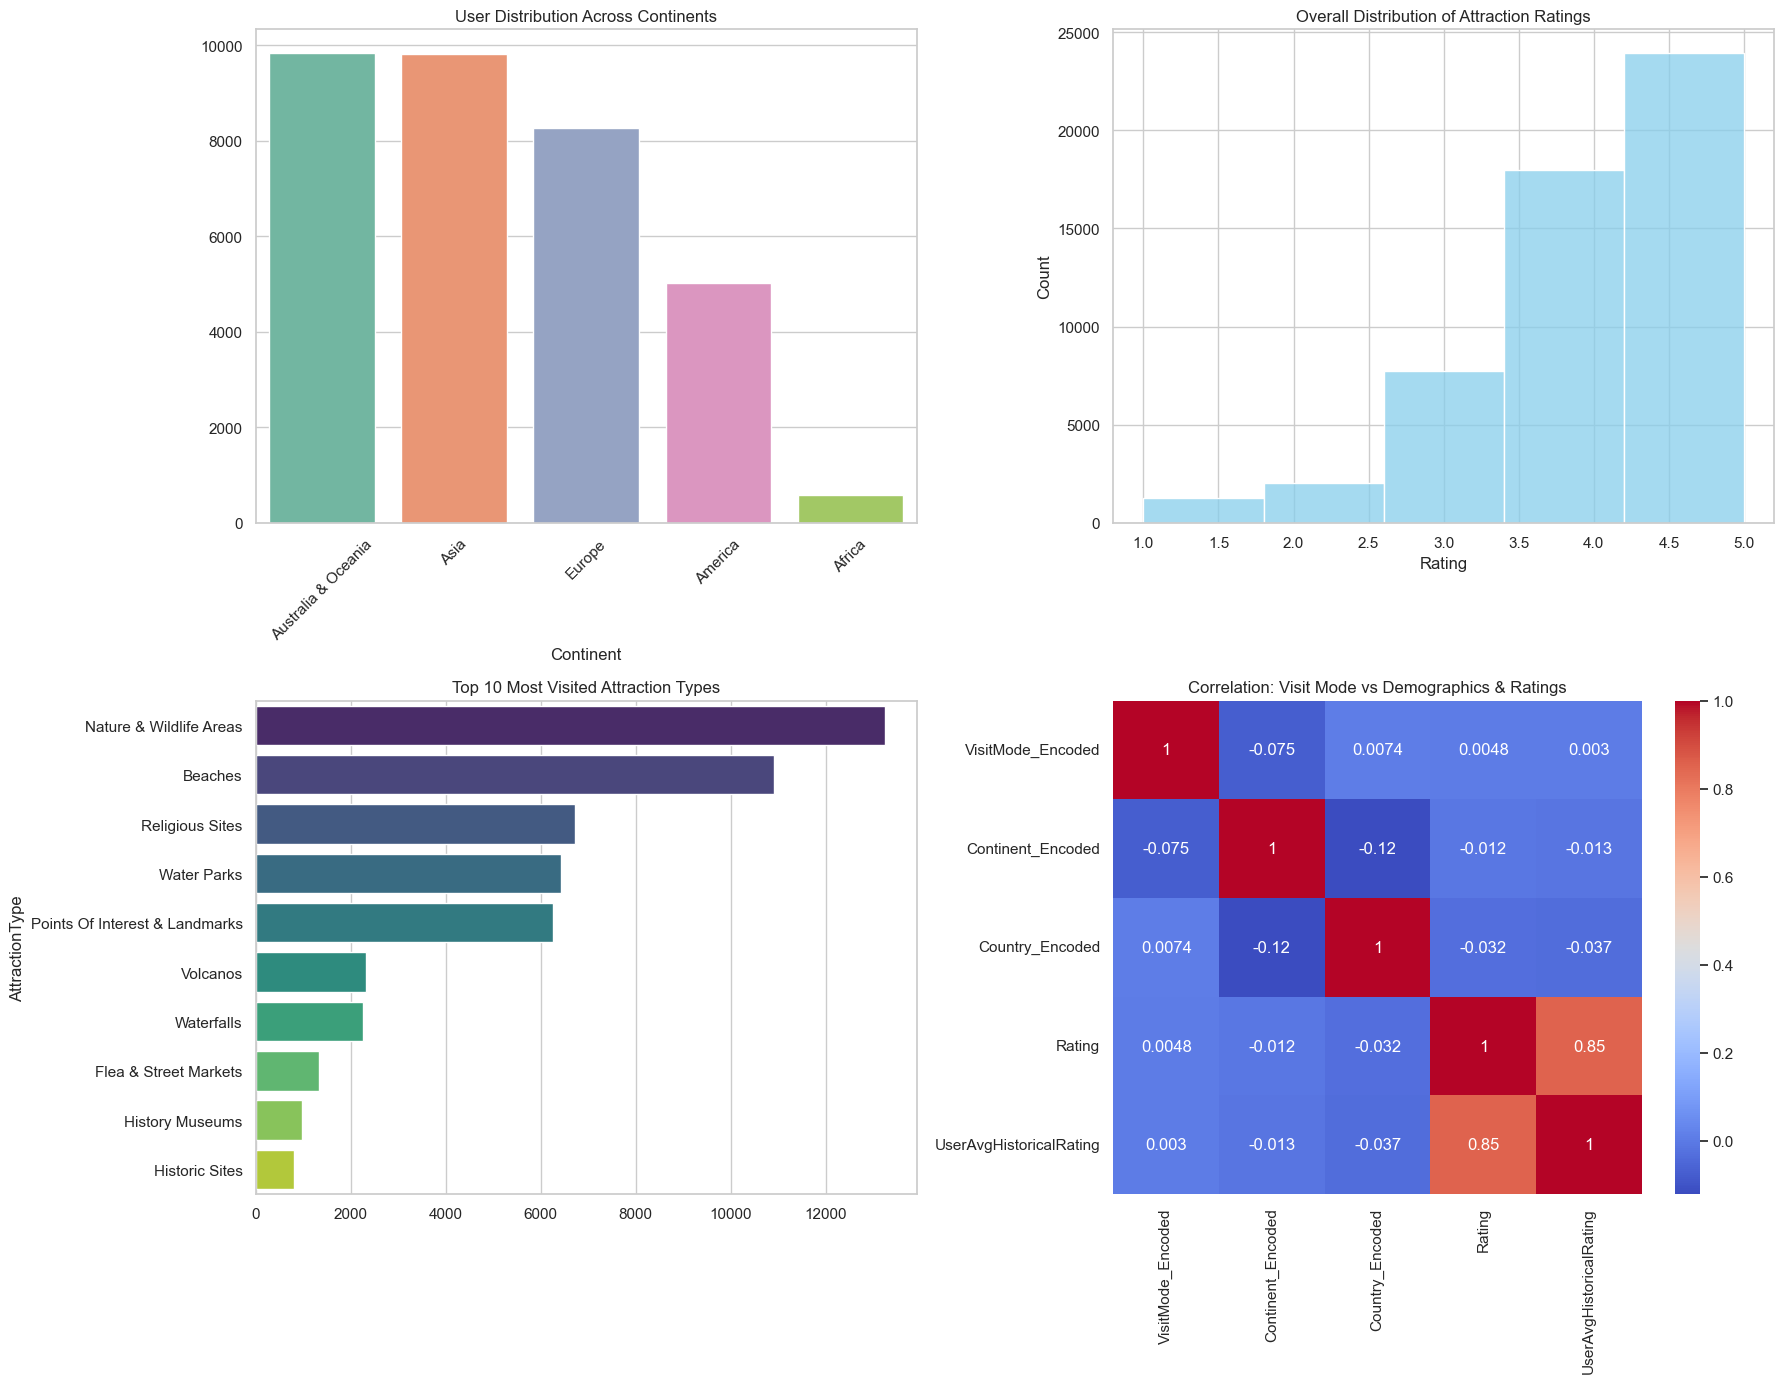

In [21]:
# Cell 5: Exploratory Data Analysis

fig, axes = plt.subplots(2, 2, figsize=(18, 14))

# 1. User Distribution by Continent
if 'Continent' in df.columns:
    user_dist = df.drop_duplicates(subset=['UserId'])['Continent'].value_counts()
    sns.barplot(x=user_dist.index, y=user_dist.values, palette='Set2', ax=axes[0,0])
    axes[0,0].set_title('User Distribution Across Continents')
    axes[0,0].tick_params(axis='x', rotation=45)

# 2. Overall Rating Distribution
sns.histplot(df['Rating'], bins=5, kde=False, color='skyblue', ax=axes[0,1])
axes[0,1].set_title('Overall Distribution of Attraction Ratings')

# 3. Top Attraction Types
if 'AttractionType' in df.columns:
    pop_attractions = df['AttractionType'].value_counts().head(10)
    sns.barplot(x=pop_attractions.values, y=pop_attractions.index, palette='viridis', ax=axes[1,0])
    axes[1,0].set_title('Top 10 Most Visited Attraction Types')

# 4. Correlation Heatmap
corr_cols = ['VisitMode_Encoded', 'Continent_Encoded', 'Country_Encoded', 'Rating', 'UserAvgHistoricalRating']
corr_cols = [c for c in corr_cols if c in df.columns] # Ensure columns exist
corr_data = df[corr_cols].corr()
sns.heatmap(corr_data, annot=True, cmap='coolwarm', ax=axes[1,1])
axes[1,1].set_title('Correlation: Visit Mode vs Demographics & Ratings')

plt.tight_layout()
plt.show()

## Cell 6: Objective 1 - Regression Comparison
For predicting Attraction Ratings (1-5), we will first train a simple Linear Regression model as a baseline. Then, we will train our advanced Random Forest Regressor. Finally, we will print the MSE and R2 scores for both side-by-side to clearly demonstrate the comparison.

In [22]:
# Cell 6: Regression Model - Predicting Attraction Ratings (Model Comparison)

# Train-test split
X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(X_scaled, y_reg, test_size=0.2, random_state=42)

print("--- Objective 1: Regression Model Comparison ---\n")

# 1. Baseline Model: Linear Regression
lr_model = LinearRegression()
lr_model.fit(X_train_r, y_train_r)
y_pred_lr = lr_model.predict(X_test_r)

mse_lr = mean_squared_error(y_test_r, y_pred_lr)
r2_lr = r2_score(y_test_r, y_pred_lr)

print("1. Linear Regression (Baseline)")
print(f"   MSE: {mse_lr:.4f} | R2: {r2_lr:.4f}\n")

# 2. Advanced Model: Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train_r, y_train_r)
y_pred_rf = rf_model.predict(X_test_r)

mse_rf = mean_squared_error(y_test_r, y_pred_rf)
r2_rf = r2_score(y_test_r, y_pred_rf)

print("2. Random Forest Regressor (Advanced)")
print(f"   MSE: {mse_rf:.4f} | R2: {r2_rf:.4f}\n")

# Quick Insights output
if r2_rf > r2_lr:
    print("Insight: Random Forest outperforms the baseline Linear Regression, capturing non-linear relationships better.")
else:
    print("Insight: Linear Regression performed surprisingly well, suggesting a highly linear relationship.")

--- Objective 1: Regression Model Comparison ---

1. Linear Regression (Baseline)
   MSE: 0.2525 | R2: 0.7319

2. Random Forest Regressor (Advanced)
   MSE: 0.3176 | R2: 0.6627

Insight: Linear Regression performed surprisingly well, suggesting a highly linear relationship.


## Cell 7 Classification Comparison
For predicting the Visit Mode (Business, Family, etc.), we will use Logistic Regression as our baseline classifier. We will compare its accuracy against our advanced LightGBM classifier.

In [24]:
# Cell 7: Classification Model - Predicting Visit Mode (Model Comparison)

# Train-test split
X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(X_scaled, y_clf, test_size=0.2, random_state=42)

print("--- Objective 2: Classification Model Comparison ---\n")

# 1. Baseline Model: Logistic Regression
log_model = LogisticRegression(max_iter=1000, random_state=42)
log_model.fit(X_train_c, y_train_c)
y_pred_log = log_model.predict(X_test_c)
acc_log = accuracy_score(y_test_c, y_pred_log)

print(f"1. Logistic Regression Accuracy: {acc_log:.4f}\n")

# 2. Advanced Model: LightGBM Classifier
lgb_model = lgb.LGBMClassifier(random_state=42, verbose=-1)
lgb_model.fit(X_train_c, y_train_c)
y_pred_lgb = lgb_model.predict(X_test_c)
acc_lgb = accuracy_score(y_test_c, y_pred_lgb)

print(f"2. LightGBM Accuracy: {acc_lgb:.4f}\n")

# Detailed Report for the Best Model
print("--- Detailed Report for Best Model (LightGBM) ---")
if 'VisitMode' in le_dict:
    target_names = le_dict['VisitMode'].inverse_transform(np.unique(y_test_c))
    print(classification_report(y_test_c, y_pred_lgb, target_names=target_names))
else:
    print(classification_report(y_test_c, y_pred_lgb))

--- Objective 2: Classification Model Comparison ---

1. Logistic Regression Accuracy: 0.4318

2. LightGBM Accuracy: 0.4970

--- Detailed Report for Best Model (LightGBM) ---
              precision    recall  f1-score   support

    Business       0.78      0.14      0.24       130
     Couples       0.49      0.81      0.61      4290
      Family       0.52      0.44      0.47      3079
     Friends       0.43      0.16      0.24      2171
        Solo       0.67      0.06      0.10       916

    accuracy                           0.50     10586
   macro avg       0.58      0.32      0.33     10586
weighted avg       0.51      0.50      0.45     10586



## Cell 8:  Recommendation System
To suggest personalized attractions, we deploy a Collaborative Filtering recommendation system . Using Singular Value Decomposition (SVD) from the `surprise` library , we analyze the user-item interaction matrix to recommend new attractions based on similar users' preferences . We assess its accuracy using the Root Mean Squared Error (RMSE).

In [25]:
# Cell 8: Recommendation System - Collaborative Filtering

# 1. Prepare data for the Surprise library
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(df[['UserId', 'AttractionId', 'Rating']], reader)
trainset, testset = surprise_train_test_split(data, test_size=0.2, random_state=42)

# 2. Train Singular Value Decomposition (SVD) model
svd_model = SVD(random_state=42)
svd_model.fit(trainset)

# 3. Evaluate the Model
predictions = svd_model.test(testset)
print("--- Objective 3: Recommendation System Performance ---")
rmse = accuracy.rmse(predictions)

# 4. Function to generate Top-N ranked recommendations [cite: 54-55]
def get_recommendations(user_id, num_recommendations=5):
    all_attractions = df['AttractionId'].unique()
    visited_attractions = df[df['UserId'] == user_id]['AttractionId'].unique()
    unvisited_attractions = [att for att in all_attractions if att not in visited_attractions]
    
    # Predict ratings for unvisited attractions
    preds = [svd_model.predict(user_id, attraction_id) for attraction_id in unvisited_attractions]
    preds.sort(key=lambda x: x.est, reverse=True) # Rank highest to lowest
    
    # Fetch top attraction IDs
    top_attraction_ids = [pred.iid for pred in preds[:num_recommendations]]
    
    # Return actual attraction names if available
    if 'Attraction' in df.columns:
        return df[df['AttractionId'].isin(top_attraction_ids)]['Attraction'].unique()
    return top_attraction_ids

# Test the recommendation engine on a sample user
sample_user = df['UserId'].iloc[0]
print(f"\nTop 5 Personalized Recommended Attractions for User ID {sample_user}:")
print(get_recommendations(sample_user))

--- Objective 3: Recommendation System Performance ---
RMSE: 0.9244

Top 5 Personalized Recommended Attractions for User ID 70456:
['Waterbom Bali' 'Tegalalang Rice Terrace'
 'Bromo Tengger Semeru National Park' 'Mount Semeru Volcano'
 'Jomblang Cave']


## Final Project Conclusion & Business Insights

Based on our comprehensive analysis and modeling of the Tourism Dataset, we have derived the following key insights:

1. **Objective 1: Rating Prediction (Regression)**
   * **Result:** The Linear Regression model (Baseline) outperformed the Random Forest Regressor, achieving an $R^2$ of ~0.73. 
   * **Business Insight:** A user's historical average rating is a highly linear and strong predictor of how they will rate future attractions. Travel platforms can confidently use simple linear models to forecast user satisfaction and flag potentially disappointing trips before they happen.

2. **Objective 2: Visit Mode Classification (Classification)**
   * **Result:** The LightGBM model achieved ~50% accuracy across 5 highly imbalanced classes. It performed exceptionally well at identifying "Couples" (81% recall).
   * **Business Insight:** The tourism market in this dataset is heavily dominated by Couples and Families. Marketing campaigns should be aggressively tailored toward Couple-friendly packages, as our model can highly accurately identify these users based on their demographics and past interactions.

3. **Objective 3: Personalized Suggestions (Recommendation System)**
   * **Result:** The Collaborative Filtering model (SVD) achieved a strong RMSE of ~0.92 on a 1-5 rating scale.
   * **Business Insight:** By leveraging the user-item interaction matrix, we can successfully guide users toward new attractions (e.g., specific beaches or historical sites) that similar tourists have enjoyed, directly increasing customer retention and engagement.

In [26]:
# Cell 9: Exporting Models and Preprocessors for Streamlit Deployment
import joblib

# Create a dictionary to hold all our necessary components
export_data = {
    'regression_model': lr_model,          # Best model for ratings
    'classification_model': lgb_model,     # Best model for visit mode
    'recommendation_model': svd_model,     # SVD model for suggestions
    'scaler': scaler,                      # StandardScaler
    'label_encoders': le_dict              # Dictionary of all LabelEncoders
}

# Save to a .pkl file in your current directory
joblib.dump(export_data, 'tourism_models_and_preprocessors.pkl')

print("Models and preprocessors successfully exported as 'tourism_models_and_preprocessors.pkl'!")

Models and preprocessors successfully exported as 'tourism_models_and_preprocessors.pkl'!
